# Tutorial demonstrating verification of v1 precip against jra55

#### Import pyLatte package

In [1]:
from pylatte import utils
from pylatte import verif

#### Currently, the following packages are required to load the data - this process will be replaced by the CAFE cookbook

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import warnings    
warnings.filterwarnings("ignore")

# Jupyter specific -----
%matplotlib inline

#### The pyLatte package is constructed around the xarray Python package. This is particularly useful for verification computations which require large numbers of samples (different model runs) to converge. 

#### The approach here is to generate very large xarray objects that reference all data required for the verification, but do not store the data in memory. Operations are performed on these xarray objects out-of-memory. When it is necessary to perform a compute (e.g. to produce a plot), this is distributed over multiple processors using the dask Python package.

# Initialise dask (currently not working on vm31)

In [3]:
# import dask
# import distributed
# client = distributed.Client(local_dir='/tmp/squ027-dask-worker-space', n_workers=4)
# zclient

# Construct xarray objects for forecasts and observations

#### (The CAFE cookbook will replace these code blocks)

In [4]:
# Resampling details -----
resample_freq = '1MS' # Must be '1MS' for monthly
resample_method = 'sum'

# Location of forecast data -----
fcst_folder = '/OSM/CBR/OA_DCFP/data/model_output/CAFE/forecasts/v1/'
fcst_filename = 'atmos_daily*'

# Location of observation data -----
obsv_folder = '/OSM/CBR/OA_DCFP/data/observations/jra55/isobaric/061_tprat/'
obsv_filename = 'anl_surf125.002_prmsl.'

In [5]:
# Initialization dates (takes approximately 1 min 30 sec per date) -----
init_dates = pd.date_range('2/2002','6/2005' , freq='1MS')  # Must be '1MS' for monthly

# Ensembles to include -----
ensembles = range(1,12)

# Forecast length -----
FCST_LENGTH = 2 # years
no_leap = 2001
n_incr = len(pd.date_range('1/1/' + str(no_leap),
                           '12/1/' + str(no_leap+FCST_LENGTH-1),
                           freq=resample_freq)) # number of lead_time increments
lead_times = range(1,n_incr+1)

### Construct forecasts xarray object

In [6]:
# import pdb, traceback, sys
filename = 'atmos_daily*'

# ==================================================
# Initialize xarray object for first init_date -----
# ==================================================
with utils.timer():
    print(f'Gathering data for forecast started on {init_dates[0].month}-{init_dates[0].year}...')
    
    ds_fcst = xr.open_mfdataset(fcst_folder + 
                                '/yr' + str(init_dates[0].year) + 
                                '/mn' + str(init_dates[0].month) + 
                                '/OUTPUT.' + str(ensembles[0]) + 
                                '/' + filename, autoclose=True)
    ds_fcst.coords['ensemble'] = ensembles[0]

    for ensemble in ensembles[1:]:
        ds_temp = xr.open_mfdataset(fcst_folder + 
                                    '/yr' + str(init_dates[0].year) + 
                                    '/mn' + str(init_dates[0].month) + 
                                    '/OUTPUT.' + str(ensemble) + 
                                    '/' + filename, autoclose=True)
        # Concatenate along 'ensemble' dimension/coordinate -----
        ds_temp.coords['ensemble'] = ensemble
        ds_fcst = xr.concat([ds_fcst, ds_temp],'ensemble')

    # Resample to desired frequency and resave time as lead time -----
    ds_fcst = ds_fcst.resample(freq=resample_freq, dim='time', how=resample_method) \
                               .isel(time = range(len(lead_times)))
    ds_fcst = ds_fcst.rename({'time' : 'lead_time'})
    ds_fcst['lead_time'] = lead_times

    # Initialize 'init_date' coordinate -----
    ds_fcst.coords['init_date'] = init_dates[0]
    ds_fcst = ds_fcst.expand_dims('init_date')
    
# ==============================================
# Loop over remaining initialization dates -----
# ==============================================
for init_date in init_dates[1:]:
    with utils.timer():
        year = init_date.year
        month = init_date.month
        print(f'Gathering data for forecast started on {month}-{year}...')

        # There is a bug in xarray that causes an 'invalid type promotion' sometimes when concatenating 
        # The following while loop provides a work-around 
        more_ensembles = True
        first_chunk = True
        current_ensemble = 1

        while more_ensembles:
            try:
                # Initialize xarray object for first ensemble -----
                ds_temp1 = xr.open_mfdataset(fcst_folder + 
                                             '/yr' + str(year) + 
                                             '/mn' + str(month) + 
                                             '/OUTPUT.' + str(ensembles[current_ensemble-1]) + 
                                             '/' + filename, autoclose=True)
                ds_temp1.coords['ensemble'] = ensembles[current_ensemble-1]

                for ensemble in ensembles[current_ensemble:]:
                    ds_temp2 = xr.open_mfdataset(fcst_folder + 
                                                '/yr' + str(year) + 
                                                '/mn' + str(month) + 
                                                '/OUTPUT.' + str(ensemble) + 
                                                '/' + filename, autoclose=True)
                    # Concatenate along 'ensemble' dimension/coordinate -----
                    ds_temp2.coords['ensemble'] = ensemble
                    ds_temp1 = xr.concat([ds_temp1, ds_temp2],'ensemble')

                # try:
                if first_chunk:
                    ds_chunk = ds_temp1
                else:
                    ds_chunk = xr.concat([ds_chunk, ds_temp1],'ensemble')
                # except:
                #     type, value, tb = sys.exc_info()
                #     traceback.print_exc()
                #     pdb.post_mortem(tb)

                more_ensembles = False
            except TypeError:
                if first_chunk:
                    ds_chunk = ds_temp1
                    first_chunk = False
                else:
                    ds_chunk = xr.concat([ds_chunk, ds_temp1],'ensemble')
                current_ensemble = ensemble

        # Resample to desired frequency and resave time as lead time -----
        ds_chunk = ds_chunk.resample(freq=resample_freq, dim='time', how=resample_method) \
                           .isel(time = range(len(lead_times)))
        ds_chunk = ds_chunk.rename({'time' : 'lead_time'})
        ds_chunk['lead_time'] = lead_times

        # Concaneate along 'init_date' dimension/coordinate -----
        ds_chunk.coords['init_date'] = init_date
        ds_fcst = xr.concat([ds_fcst, ds_chunk],'init_date')

Gathering data for forecast started on 2-2002...
   Elapsed: 5.7789013385772705 sec
Gathering data for forecast started on 3-2002...
   Elapsed: 5.699721813201904 sec
Gathering data for forecast started on 4-2002...
   Elapsed: 5.970451593399048 sec
Gathering data for forecast started on 5-2002...
   Elapsed: 5.820870399475098 sec
Gathering data for forecast started on 6-2002...
   Elapsed: 5.895660400390625 sec
Gathering data for forecast started on 7-2002...
   Elapsed: 17.260574340820312 sec
Gathering data for forecast started on 8-2002...
   Elapsed: 5.450462102890015 sec
Gathering data for forecast started on 9-2002...
   Elapsed: 6.776714563369751 sec
Gathering data for forecast started on 10-2002...
   Elapsed: 7.028425931930542 sec
Gathering data for forecast started on 11-2002...
   Elapsed: 5.50873875617981 sec
Gathering data for forecast started on 12-2002...
   Elapsed: 7.189594268798828 sec
Gathering data for forecast started on 1-2003...
   Elapsed: 12.397732496261597 sec

#### Rechunk

In [7]:
with utils.timer():
    # Rechunk for chunksizes of at least 1,000,000 elements -----
    ds_fcst = ds_fcst.chunk(chunks={'ensemble' : len(ensembles), 'lead_time' : len(lead_times)})

    # Overwrite init_dates in case didn't fully load -----
    init_dates = ds_fcst.init_date.values

   Elapsed: 10.654499769210815 sec


### Construct observations xarray object

In [8]:
filename = 'fcst_phy2m125.061_tprat.'

fcst_years = [pd.to_datetime(init_dates).year]
fcst_year_min = min(fcst_years)[0]
fcst_year_max = max(fcst_years)[-1] + FCST_LENGTH

# ===================================================
# Only load years for which forecast data exist -----
# ===================================================
with utils.timer():
    print(f'Gathering data for observations...')
    
    ds_temp1 = xr.open_mfdataset(obsv_folder + filename + str(fcst_year_min) + '*', 
                                 autoclose=True)
    for year_to_load in range(fcst_year_min+1,fcst_year_max+1):
        ds_temp2 = xr.open_mfdataset(obsv_folder + filename + str(year_to_load) + '*', 
                                     autoclose=True)
        ds_temp1 = xr.concat([ds_temp1, ds_temp2],'initial_time0_hours')

    # Standardize naming -----
    ds_temp1 = ds_temp1.rename({'initial_time0_hours':'time',
                                      'g0_lon_3':'lon',
                                      'g0_lat_2':'lat',
                                      'TPRAT_GDS0_SFC_ave3h':'precip'})

    # Resample to desired frequency -----
    ds_temp1 = ds_temp1.resample(freq=resample_freq, dim='time', how=resample_method)
    
    # ===============================================
    # Stack to resemble ds_forecast coordinates -----
    # ===============================================
    # Initialize xarray object for first lead_time -----
    start_index = np.where(ds_temp1.time == np.datetime64(init_dates[0]))[0].item()
    ds_obsv = ds_temp1.isel(time=range(start_index, start_index+len(lead_times)))
    ds_obsv.coords['init_date'] = init_dates[0]
    ds_obsv = ds_obsv.expand_dims('init_date')
    ds_obsv = ds_obsv.rename({'time' : 'lead_time'})
    ds_obsv['lead_time'] = lead_times
    
    # Loop over remaining lead_time -----
    for init_date in init_dates[1:]:
        start_index = np.where(ds_temp1.time == np.datetime64(init_date))[0].item()
        ds_temp3 = ds_temp1.isel(time=range(start_index, start_index+len(lead_times)))

        # Concatenate along 'lead_time' dimension/coordinate -----
        ds_temp3 = ds_temp3.rename({'time' : 'lead_time'})
        ds_temp3['lead_time'] = lead_times
        ds_temp3.coords['init_date'] = init_date
        ds_obsv = xr.concat([ds_obsv, ds_temp3],'init_date') 

Gathering data for observations...
   Elapsed: 1.268319845199585 sec


#### Rechunk

In [9]:
with utils.timer():
    # Rechunk for chunksizes of at least 1,000,000 elements -----
    ds_obsv = ds_obsv.chunk(chunks={'init_date' : len(init_dates)})

   Elapsed: 0.018278837203979492 sec


# Skill metrics for probabilistic forecasts

##### E.g. for the event of monthly rainfall over Tasmania being greater than 100 mm/month but less than 600 mm/month

In [10]:
# Region of interest -----
region = (-44.0, -40.0, 144.0 , 148.0) # (lat_min,lat_max,lon_min,lon_max)

da_fcst = utils.calc_boxavg_latlon(ds_fcst['precip'] * 60 * 60 * 24 / 998.2 * 1000, region).compute()

# The jra55 precip data is saved with 3hr and 6hr forecasts as an additional dimension - deal with these -----
da_obsv = utils.calc_boxavg_latlon(1 / 8 * ds_obsv['precip'].sum(dim='forecast_time1'), region).compute()

In [11]:
event = '(> 100) and (< 600)'

### Plot one initialization date

In [12]:
da_fcst

<xarray.DataArray (init_date: 41, lead_time: 24, ensemble: 11)>
array([[[  96.083781,   90.111595, ...,  102.598581,  114.693984],
        [  80.583069,   73.271509, ...,   85.456258,   40.503239],
        ..., 
        [  58.641875,   81.751674, ...,   67.83963 ,   74.523648],
        [  41.146618,   42.962835, ...,   44.084084,   14.485252]],

       [[  98.68436 ,  115.131684, ...,  110.555286,  102.30912 ],
        [ 147.322334,  113.95375 , ...,   85.935548,  115.848742],
        ..., 
        [  43.192908,   24.586522, ...,   28.307417,   30.098507],
        [  49.183403,   36.337477, ...,   43.470431,   76.676735]],

       ..., 
       [[ 115.502345,  114.685153, ...,  116.20838 ,   88.468342],
        [ 140.644699,  111.474472, ...,  112.555536,   97.591698],
        ..., 
        [  53.382145,   50.096881, ...,   37.429866,   46.341981],
        [  64.08208 ,  112.168148, ...,   86.990952,   77.817519]],

       [[ 133.757853,  123.274833, ...,  154.101906,  114.602894],
    

In [13]:
da_obsv

<xarray.DataArray (init_date: 41, lead_time: 24)>
array([[  43.006944,   40.465278,   26.695312, ...,   22.958767,   67.87934 ,
          93.94184 ],
       [  40.465278,   26.695312,   36.135417, ...,   67.87934 ,   93.94184 ,
          44.451823],
       [  26.695312,   36.135417,  150.776476, ...,   93.94184 ,   44.451823,
          42.263889],
       ..., 
       [  78.296007,   44.71658 ,   74.077257, ...,  109.217014,   32.142361,
          65.144965],
       [  44.71658 ,   74.077257,   94.182726, ...,   32.142361,   65.144965,
          32.701823],
       [  74.077257,   94.182726,  150.44184 , ...,   65.144965,   32.701823,
         163.236545]])
Coordinates:
  * lead_time  (lead_time) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * init_date  (init_date) datetime64[ns] 2002-02-01 2002-03-01 2002-04-01 ...

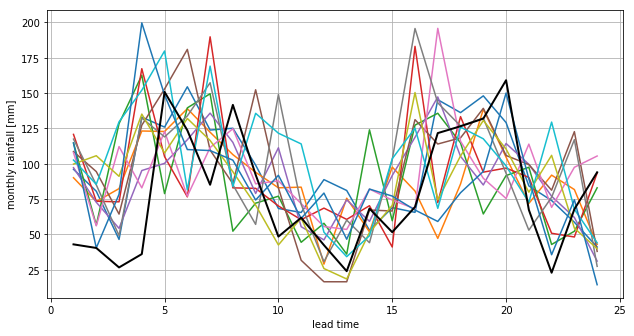

In [14]:
fig1 = plt.figure(figsize=(10,5))

ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
ax.plot(da_fcst['lead_time'],da_fcst.isel(init_date=[0]).squeeze())
ax.plot(da_obsv['lead_time'],da_obsv.isel(init_date=[0]).squeeze(),'k-',linewidth=2)
ax.set_xlabel('lead time')
ax.set_ylabel('monthly rainfall [mm]');

## Reliability diagram

#### Compute reliability as a function of lead time 

In [15]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = verif.compute_likelihood(verif.did_event(da_fcst, event))
    obsv_logical = verif.did_event(da_obsv, event)

    # Compute the reliability -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])+1)
    reliability = verif.compute_reliability(fcst_likelihood,obsv_logical,
                                            fcst_probabilities,indep_dims='init_date')

   Elapsed: 0.10314035415649414 sec


   Elapsed: 1.4635400772094727 sec


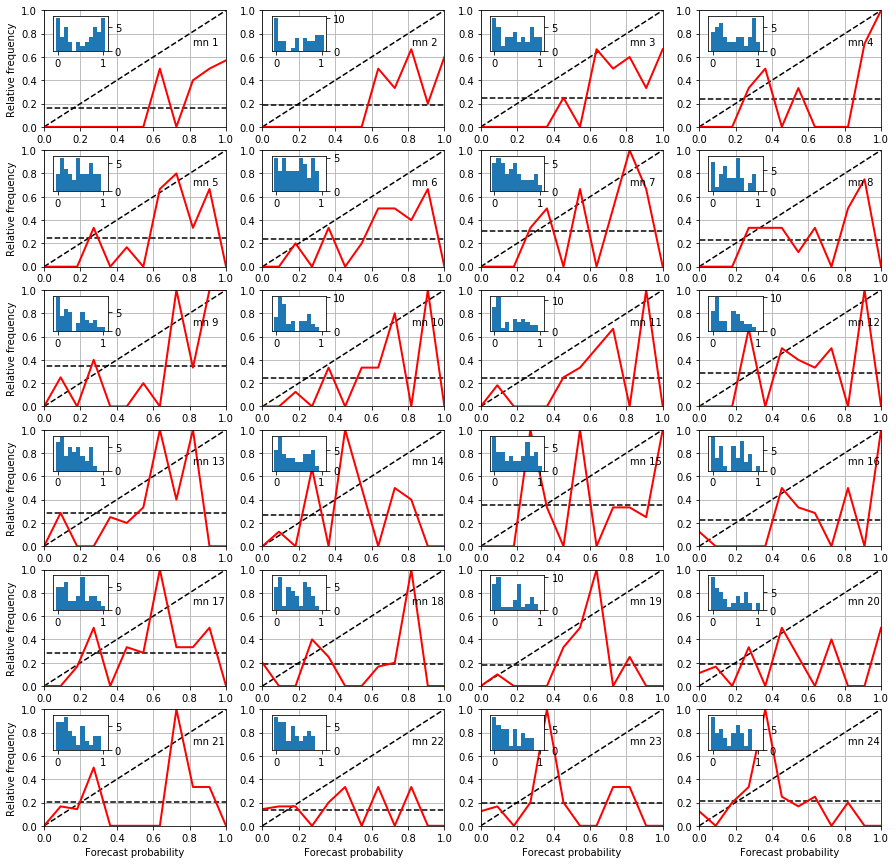

In [16]:
with utils.timer():
    ncol = 4; nrow = int(np.ceil(len(lead_times)/ncol));
    fig, axs = plt.subplots(figsize=(15,15), nrows=nrow, ncols=ncol);

    for idx,ax in enumerate(axs.reshape(-1)): 
        ax.grid()
        ax.plot([0, 1],[0, 1],'k--')
        sample_clim = reliability['relative_freq'].isel(lead_time=idx, drop=True).mean()
        ax.plot([-1, 2],[sample_clim, sample_clim],'k--')
        ax.plot(reliability['forecast_probability'],
                reliability['relative_freq'].isel(lead_time=idx, drop=True),'r',linewidth=2)
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0.82,0.7,'mn '+str(idx+1))

        if idx % ncol == 0:
            ax.set_ylabel('Relative frequency')

        if idx / ncol >= nrow - 1:
            ax.set_xlabel('Forecast probability')

        fig = plt.gcf()
        box = ax.get_position()
        width = box.width
        height = box.height
        subpos = [0.05,0.65,0.3,0.3]
        inax_position  = ax.transAxes.transform(subpos[0:2])
        transFigure = fig.transFigure.inverted()
        infig_position = transFigure.transform(inax_position)    
        x = infig_position[0]
        y = infig_position[1]
        width *= subpos[2]
        height *= subpos[3] 
        subax = fig.add_axes([x,y,width,height])
        subax.yaxis.tick_right()
        subax.bar(reliability['forecast_probability'],reliability['fcst_number'].isel(lead_time=idx, drop=True),
                  width=reliability['forecast_probability'][1])

#### Compute reliability across all lead times

In [17]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = verif.compute_likelihood(verif.did_event(da_fcst, event))
    obsv_logical = verif.did_event(da_obsv, event)

    # Compute the reliability -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])+1)
    reliability = verif.compute_reliability(fcst_likelihood,obsv_logical,fcst_probabilities,
                                            indep_dims=['init_date','lead_time'])

   Elapsed: 0.09071898460388184 sec


   Elapsed: 0.06938910484313965 sec


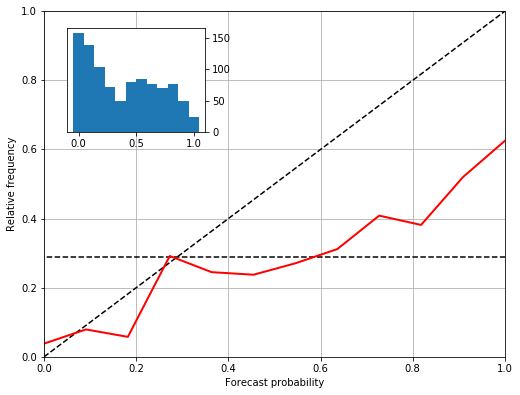

In [18]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,6))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot([0, 1],[0, 1],'k--')
    sample_clim = reliability['relative_freq'].mean()
    ax.plot([-1, 2],[sample_clim, sample_clim],'k--')
    ax.plot(reliability['forecast_probability'],reliability['relative_freq'],'r',linewidth=2)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('Forecast probability')
    ax.set_ylabel('Relative frequency');

    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    subpos = [0.05,0.65,0.3,0.3]
    inax_position  = ax.transAxes.transform(subpos[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= subpos[2]
    height *= subpos[3] 
    subax = fig.add_axes([x,y,width,height])
    subax.yaxis.tick_right()
    subax.bar(reliability['forecast_probability'],reliability['fcst_number'],
              width=reliability['forecast_probability'][1]);

## Brier score

#### Compute Brier scores as a function of lead time

In [19]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = verif.compute_likelihood(verif.did_event(da_fcst, event))
    obsv_logical = verif.did_event(da_obsv, event)

    # Compute the Brier score -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])-6)
    Brier = verif.compute_Brier_score(fcst_likelihood,obsv_logical,fcst_prob=fcst_probabilities,
                                      indep_dims='init_date')

   Elapsed: 0.11915898323059082 sec


   Elapsed: 0.03754258155822754 sec


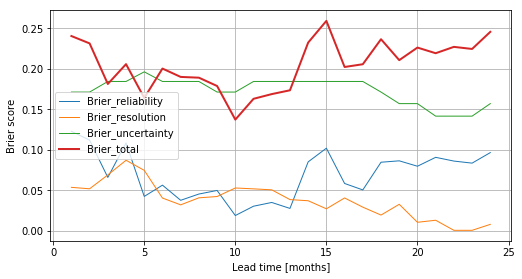

In [20]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot(Brier['lead_time'],Brier['Brier_reliability'],linewidth=1)
    ax.plot(Brier['lead_time'],Brier['Brier_resolution'],linewidth=1)
    ax.plot(Brier['lead_time'],Brier['Brier_uncertainty'],linewidth=1)
    ax.plot(Brier['lead_time'],Brier['Brier_total'],linewidth=2)
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Brier score')
    ax.legend();

## Relative operating characteristic

#### Compute ROC diagrams as a function of lead time

In [21]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = verif.compute_likelihood(verif.did_event(da_fcst, event))
    obsv_logical = verif.did_event(da_obsv, event)

    # Compute the roc -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])+1)
    roc = verif.compute_roc(fcst_likelihood, obsv_logical, fcst_probabilities, 
                            indep_dims='init_date')

   Elapsed: 0.3444099426269531 sec


   Elapsed: 0.5588464736938477 sec


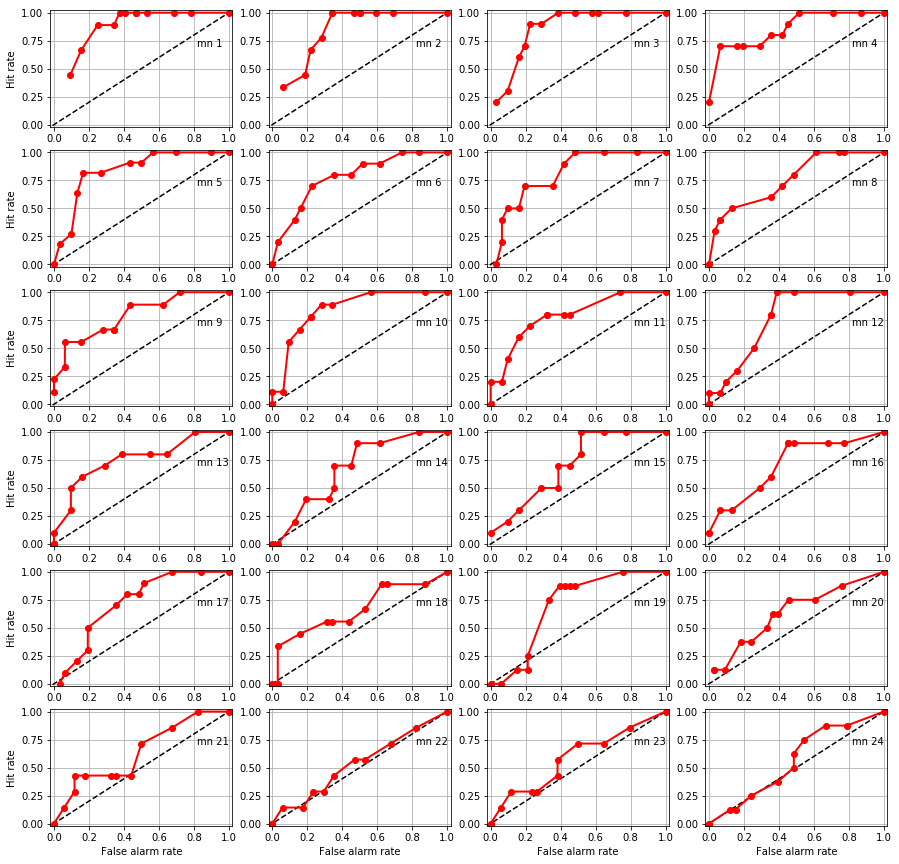

In [22]:
with utils.timer():
    ncol = 4; nrow = int(np.ceil(len(lead_times)/ncol));
    fig, axs = plt.subplots(figsize=(15,15), nrows=nrow, ncols=ncol);

    for idx,ax in enumerate(axs.reshape(-1)): 
        ax.grid()
        ax.plot([-1, 2],[-1, 2],'k--')
        ax.plot(roc['false_alarm_rate'].isel(lead_time=idx, drop=True),
                roc['hit_rate'].isel(lead_time=idx, drop=True),'ro-',linewidth=2)
        ax.set_xlim(-0.02,1.02)
        ax.set_ylim(-0.02,1.02)
        ax.text(0.82,0.7,'mn '+str(idx+1))

        if idx % ncol == 0:
            ax.set_ylabel('Hit rate')

        if idx / ncol >= nrow - 1:
            ax.set_xlabel('False alarm rate')

#### Compute ROC diagram for all lead times

In [23]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = verif.compute_likelihood(verif.did_event(da_fcst, event))
    obsv_logical = verif.did_event(da_obsv, event)

    # Compute the roc -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])+1)
    roc = verif.compute_roc(fcst_likelihood, obsv_logical, fcst_probabilities, 
                            indep_dims=('init_date','lead_time'))

   Elapsed: 0.27622008323669434 sec


   Elapsed: 0.027008771896362305 sec


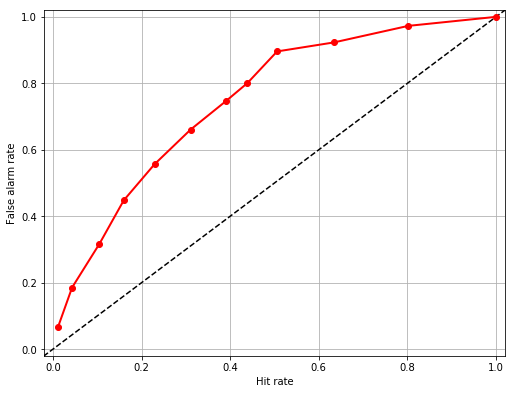

In [24]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,6))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot([-1, 2],[-1, 2],'k--')
    ax.plot(roc['false_alarm_rate'],roc['hit_rate'],'ro-',linewidth=2)
    ax.set_xlim(-0.02,1.02)
    ax.set_ylim(-0.02,1.02)
    ax.set_xlabel('Hit rate')
    ax.set_ylabel('False alarm rate');

## Discrimination diagram

#### Compute discrimination diagrams as a function of lead time

In [25]:
with utils.timer():
    # Compute the event data for forecast likelihood and observations -----
    fcst_likelihood = verif.compute_likelihood(verif.did_event(da_fcst, event))
    obsv_logical = verif.did_event(da_obsv, event)

    # Compute the discrimination -----
    fcst_probabilities = np.linspace(0,1,len(da_fcst['ensemble'])+1)
    discrimination = verif.compute_discrimination(fcst_likelihood, obsv_logical, 
                                                   fcst_probabilities, indep_dims='init_date')

   Elapsed: 0.09936308860778809 sec


   Elapsed: 1.3068149089813232 sec


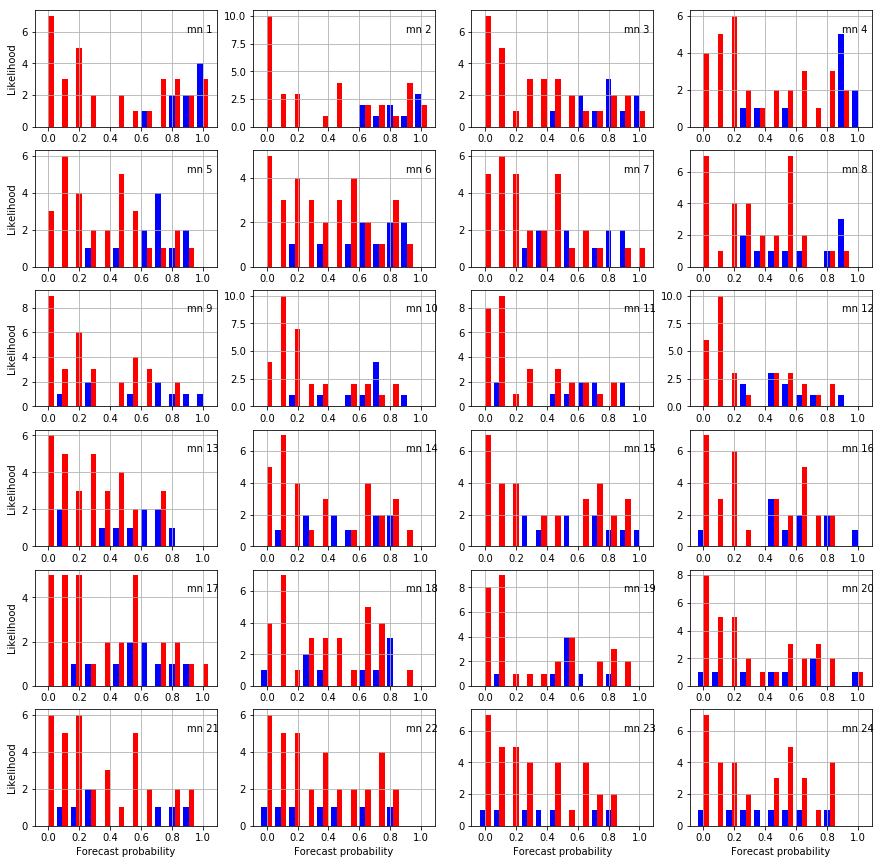

In [26]:
with utils.timer():
    ncol = 4; nrow = int(np.ceil(len(lead_times)/ncol));
    fig, axs = plt.subplots(figsize=(15,15), nrows=nrow, ncols=ncol);

    for idx,ax in enumerate(axs.reshape(-1)): 
        ax.grid()
        scale_width = 2.5
        ax.bar(discrimination.bins-discrimination.bins[1]/scale_width/2,
            discrimination['hist_obsved'].isel(lead_time=idx, drop=True),
            width=discrimination.bins[1]/scale_width,
            color='b')
        ax.bar(discrimination.bins+discrimination.bins[1]/scale_width/2,
                discrimination['hist_not_obsved'].isel(lead_time=idx, drop=True),
                width=discrimination.bins[1]/scale_width,
                color='r')
        max_count = max([discrimination['hist_obsved'].isel(lead_time=idx, drop=True).max(), 
                         discrimination['hist_not_obsved'].isel(lead_time=idx, drop=True).max()])
        ax.text(0.9,0.85*max_count,'mn '+str(idx+1))

        if idx % ncol == 0:
            ax.set_ylabel('Likelihood')

        if idx / ncol >= nrow - 1:
            ax.set_xlabel('Forecast probability')

#### Compute discrimination diagram for all lead times

In [27]:
with utils.timer():
    discrimination = verif.compute_discrimination(fcst_likelihood, obsv_logical, 
                                                  fcst_probabilities, indep_dims=('init_date','lead_time'))

   Elapsed: 0.009106159210205078 sec


   Elapsed: 0.06156611442565918 sec


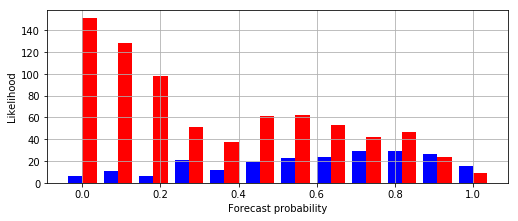

In [28]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,3))

    ax1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax1.grid()
    scale_width = 2.5
    ax1.bar(discrimination.bins-discrimination.bins[1]/scale_width/2,
            discrimination['hist_obsved'],
            width=discrimination.bins[1]/scale_width,
            color='b')
    ax1.bar(discrimination.bins+discrimination.bins[1]/scale_width/2,
            discrimination['hist_not_obsved'],
            width=discrimination.bins[1]/scale_width,
            color='r')
    ax1.set_xlabel('Forecast probability')
    ax1.set_ylabel('Likelihood');

# Skill metrics for categorized forecasts

## Contingency table

#### E.g. for 4 categories between 25 and 150 mm of monthly rainfall

In [29]:
# Define category edges -----
category_edges = np.linspace(25,150,5)

#### Compute contingency as a function of lead time

In [30]:
with utils.timer():
    # Compute contingency table -----
    contingency = verif.compute_contingency_table(da_fcst,da_obsv, category_edges,
                                                  ensemble_dim='ensemble', indep_dims=('init_date'))

   Elapsed: 0.8894095420837402 sec


   Elapsed: 0.5208604335784912 sec


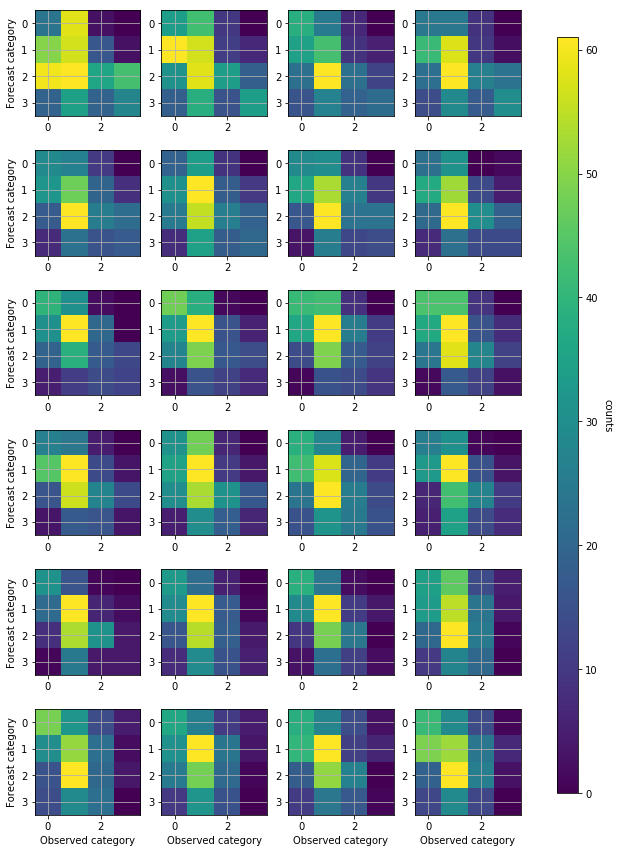

In [31]:
with utils.timer():
    ncol = 4; nrow = int(np.ceil(len(lead_times)/ncol));
    fig, axs = plt.subplots(figsize=(10,15), nrows=nrow, ncols=ncol);

    for idx,ax in enumerate(axs.reshape(-1)): 
        ax.grid()
        im = ax.imshow(contingency.isel(lead_time=idx, drop=True))
        # ax.text(0.82,0.7,'mn '+str(idx+1))

        if idx % ncol == 0:
            ax.set_ylabel('Forecast category')

        if idx / ncol >= nrow - 1:
            ax.set_xlabel('Observed category')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
    fig.colorbar(im, cax=cbar_ax);
    cbar_ax.set_ylabel('counts', rotation=270, labelpad=15);

## Accuracy score

In [32]:
with utils.timer():
    accuracy_score = verif.compute_accuracy_score(contingency)

   Elapsed: 0.005107879638671875 sec


## Heidke skill score

In [33]:
with utils.timer():
    Heidke_score = verif.compute_Heidke_score(contingency)

   Elapsed: 0.008527755737304688 sec


## Peirce skill score / Hanssen and Kuipers discriminant

In [34]:
with utils.timer():
    Peirce_score = verif.compute_Peirce_score(contingency)

   Elapsed: 0.010059595108032227 sec


## Gerrity score

In [35]:
with utils.timer():
    Gerrity_score = verif.compute_Gerrity_score(contingency)

   Elapsed: 0.11040234565734863 sec


#### Plot as a function of lead_time

   Elapsed: 0.03674936294555664 sec


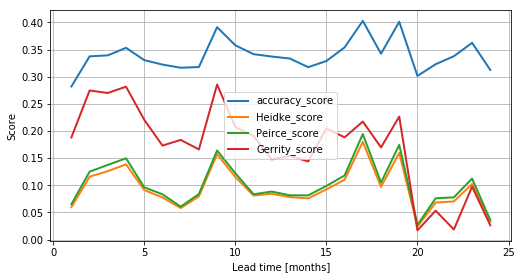

In [36]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot(accuracy_score['lead_time'],accuracy_score,linewidth=2)
    ax.plot(Heidke_score['lead_time'],Heidke_score,linewidth=2)
    ax.plot(Peirce_score['lead_time'],Peirce_score,linewidth=2)
    ax.plot(Gerrity_score['lead_time'],Gerrity_score,linewidth=2)
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Score');
    ax.legend();

# Skill metrics for dichotomously categorized forecasts

## Contingency table

#### E.g. for monthly rainfall being > or < 100 mm 

In [37]:
with utils.timer():
    # Define category edges -----
    category_edges = [-np.inf, 100, np.inf]

    # Compute contingency table -----
    contingency = verif.compute_contingency_table(da_fcst,da_obsv,category_edges,
                                                  ensemble_dim='ensemble',indep_dims=('init_date'))

   Elapsed: 0.21970891952514648 sec


## Bias score

In [38]:
with utils.timer():
    bias_score = verif.compute_bias_score(contingency)

   Elapsed: 0.0057392120361328125 sec


## Probability of detection

In [39]:
with utils.timer():
    hit_rate = verif.compute_hit_rate(contingency)

   Elapsed: 0.0032956600189208984 sec


## False alarm ratio

In [40]:
with utils.timer():
    false_alarm_ratio = verif.compute_false_alarm_ratio(contingency)

   Elapsed: 0.003480195999145508 sec


## False alarm rate

In [41]:
with utils.timer():
    false_alarm_rate = verif.compute_false_alarm_rate(contingency)

   Elapsed: 0.0032215118408203125 sec


## Success ratio

In [42]:
with utils.timer():
    success_ratio = verif.compute_success_ratio(contingency)

   Elapsed: 0.0037670135498046875 sec


## Threat score

In [43]:
with utils.timer():
    threat_score = verif.compute_threat_score(contingency)

   Elapsed: 0.004722118377685547 sec


## Equitable threat score

In [44]:
with utils.timer():
    equit_threat_score = verif.compute_equit_threat_score(contingency)

   Elapsed: 0.009020328521728516 sec


## Odds ratio

In [45]:
with utils.timer():
    odds_ratio = verif.compute_odds_ratio(contingency)

   Elapsed: 0.005782604217529297 sec


## Odds ratio skill score

In [46]:
with utils.timer():
    odds_ratio_skill = verif.compute_odds_ratio_skill(contingency)

   Elapsed: 0.01172018051147461 sec


#### Plot as a function of lead time

   Elapsed: 0.053124189376831055 sec


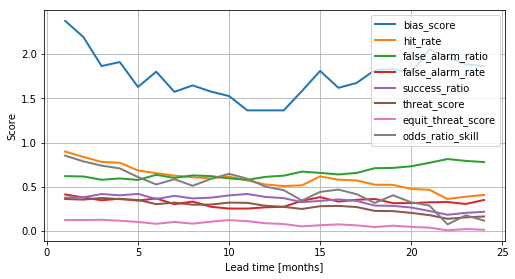

In [47]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.plot(bias_score['lead_time'],bias_score,linewidth=2)
    ax.plot(hit_rate['lead_time'],hit_rate,linewidth=2)
    ax.plot(false_alarm_ratio['lead_time'],false_alarm_ratio,linewidth=2)
    ax.plot(false_alarm_rate['lead_time'],false_alarm_rate,linewidth=2)
    ax.plot(success_ratio['lead_time'],success_ratio,linewidth=2)
    ax.plot(threat_score['lead_time'],threat_score,linewidth=2)
    ax.plot(equit_threat_score['lead_time'],equit_threat_score,linewidth=2)
    # ax.plot(odds_ratio['lead_time'],odds_ratio,linewidth=2)
    ax.plot(odds_ratio_skill['lead_time'],odds_ratio_skill,linewidth=2)
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Score');
    ax.legend();

# Close dask client

In [48]:
# with utils.timer():
#     client.close()